# Point Cloud Classification with PointNet

In [1]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Available: ", len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUs Available:  1


## Functions to Build the Model

In [3]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))
    
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()
    

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

In [4]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

In [13]:
#model.load_weights(".\\models\\pointnetweight.model")
model.load_weights("pointnetweight.model")

In [6]:
print(CLASS_MAP)

NameError: name 'CLASS_MAP' is not defined

## Compile and Train the Model

In [6]:
#mesh = trimesh.load(os.path.join(".\\", "woodenchairNoMatx90y0.obj"))
#mesh = trimesh.load(os.path.join(".\\", "OwnChairV2.obj"))
mesh = trimesh.load(os.path.join(".\\", "Prep_klappstuhl10Korrektur.obj"))
#mesh = trimesh.load(os.path.join(".\\Chairs\\", "chair_0009.off"))

mesh.show()


## Visualize The Predictions

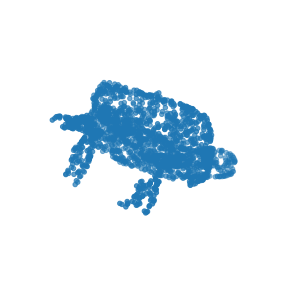

In [7]:
points = mesh.sample(2048)

points = points * 50

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [14]:
print(points.shape)
print(points)
import numpy as np

x = np.array(points)

print(x.max(axis=0))
print(x.min(axis=0))

(2048, 3)
[[ -4.78901529   6.1667824   22.73493311]
 [ 15.64390278  -9.06089313   6.47017339]
 [ 18.00689332   4.0313246    6.50394404]
 ...
 [ 19.73728952 -31.19751151  14.5138879 ]
 [-34.20960506  18.96201639  -7.5302665 ]
 [ 19.90215561  -0.41234483 -10.41469264]]
[28.93971388 39.64497905 36.8606914 ]
[-35.91290355 -39.83433289 -30.23831272]


In [15]:
data_points=[]
data_labels=[]
data_labels.append("0")
data_points.append(points)
data_points_check = tf.data.Dataset.from_tensor_slices((data_points, data_labels))
data_points_check = data_points_check.shuffle(len(data_points_check)).batch(BATCH_SIZE)

In [16]:
preds = model.predict(data_points_check)
preds = tf.math.argmax(preds, -1)

In [17]:
preds[0].numpy()

4

In [13]:
preds[0].numpy()

4